[@ggruszczynski](https://github.com/ggruszczynski)

You should have completed previous tutorial, [diffusion_part1_and_convolution](./diffusion_part1_and_convolution.ipynb) before continuing. 

Diffusion part 3: with spatially variable diffusivity in 1-D
-----
***

# Balance of Enthalpy

The simplified balance of Enthalpy $H=\rho c_p T$ is known as:
\begin{align}
\int \frac{\partial }{\partial t} (\rho c_p T ) dV +  \oint  ( \rho c_p T \boldsymbol{u} ) \cdot \boldsymbol{n} dS &= \oint \boldsymbol{n} \cdot \boldsymbol{q} dS + \int \dot{q} dV \\ 
\boldsymbol{q} &= k \nabla T
\end{align}
The heat flux $ \boldsymbol{q} $ is related to the thermal conductivity coefficient $k [ W/mK] $. 

Applying the GGO theorem, we obtain:

$$
\frac{\partial }{\partial t} (\rho c_p T ) + \nabla \cdot (\boldsymbol{u} \rho c_p T ) = \nabla \cdot (k \nabla T)  + \dot{q} 
$$




## Conservative and non-conservative scheme

Consider a 1D, unsteady heat transfer equation with variable conduction coefficient.
For simplicity, assume that the heat capacity $ \rho c_p = 1 $.

The equation be expressed in two mathematically equivalent forms:
$$
\frac{\partial u}{\partial t}=\frac{\partial}{\partial x}\left(k(x) \frac{\partial u}{\partial x}\right)
$$
or 
$$
\frac{\partial u}{\partial t}=\frac{\partial u}{\partial x} \frac{\partial k}{\partial x}+k(x) \frac{\partial^{2} u}{\partial x^{2}}
$$

Both of these continous forms can be discretized. 

First form leads to the *conservative scheme*

$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\frac{1}{\Delta x^{2}}\left(k_{i+\frac{1}{2}}\left(u_{i+1}^{n}-u_{i}^{n}\right)-k_{i-\frac{1}{2}}\left(u_{i}^{n}-u_{i-1}^{n}\right)\right)
$$


while the second form results in a *non-conservative scheme*

$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\frac{1}{\Delta x^{2}}\left(\frac{\left(k_{i+1}-k_{i-1}\right)}{2} \frac{\left(u_{i+1}^{n}-u_{i-1}^{n}\right)}{2}+k_{i}\left(u_{i+1}^{n}+u_{i-1}^{n}-2 u_{i}^{n}\right)\right)
$$


## Task

* Implement both the *conservative* and the *non-conservative* schemes.

* Impose the following BC: 

```
u[int(nx/4)] = 10.
u[-int(nx/4)] = 1.

u[0] = 5.
u[-1] = 5.
```

* Q: Run the simulation for different $k$ and compare results. Which physical quantity may become *not conserved* ?
* A: Heat flux is not conserved. Notice that computed temperature is lower than the one imposed by BC!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# variable conductivity

nx = 128
domain_length = 64
dx = domain_length / (nx-1)
xspace = np.linspace(0, domain_length, nx)

u_IC = 5.*np.ones(nx)                    # numpy function ones()
u_IC[int((nx-1)/4):int(nx/2 + 1)] = 10   # setting u = 2 between 0.5 and 1 as per our I.C.s

k = 1.*np.ones(nx)                      # be aware that dt = sigma * dx**2 / nu
k[:int(nx/2)] = 0.1                     # try with 0.1 

sigma = .2              # sigma is a parameter, we'll learn more about it later
dt = sigma * dx**2 / max(k)              #dt is defined using sigma 
nt = 50000  # the number of timesteps we want to calculate


In [3]:
def calc_diffusion_variable_conductivity_naive(IC,nx,nt,k,dt,conservative=True):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time
    

    for n in range(nt):  #iterate through time
        #impose BC
        u[int(nx/4)] = 10.
        u[-int(nx/4)] = 1.

        u[0] = 5.
        u[-1] = 5.

        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nx - 1):
            # this is obviously bad : du/dt = k (d^2)u/(dx)^2 
            # u[i] = un[i] + k[i] * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])

            
            if conservative: # conservative scheme
                kf = (k[i+1]+k[i])/2
                kb = (k[i]+k[i-1])/2
                u[i] = un[i] +  dt / dx**2 * (kf*(un[i+1]-un[i]) - kb*(un[i] - un[i-1]))
            
            else:            # non conservative scheme
                u[i] = un[i] +  dt / dx**2 * ((k[i+1]-k[i-1])*(un[i+1]-un[i-1])/4.  + k[i]*(un[i+1] - 2 * un[i] + un[i-1]))
    return u


def calc_diffusion_variable_conductivity(IC,nx,nt,nu,dt,conservative=True):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time
    beta = nu * dt / dx**2

    c_ind = np.arange(0, nx)
    l_ind = np.roll(c_ind, -1)
    r_ind = np.roll(c_ind, 1)
    
    beta = dt / dx**2
    kf = (k[r_ind]+k[c_ind])/2
    kb = (k[c_ind]+k[l_ind])/2
        
    for n in range(nt):  #iterate through time
        #impose BC
        u[int(nx/4)] = 10.
        u[-int(nx/4)] = 1.

        u[0] = 5.
        u[-1] = 5.

        un = u.copy() ##copy the existing values of u into un
            
        if conservative:
            u = un + beta * (kf*(un[r_ind]-un[c_ind]) - kb*(un[c_ind] - un[l_ind]))
        else:  # non conservative scheme
            u = un +  beta * ((k[r_ind]-k[l_ind])*(un[r_ind]-un[l_ind])/4.  + k[c_ind]*(un[r_ind] - 2 * un[c_ind] + un[l_ind]))     
                
    return u


In [4]:
# u_FD_conservative = calc_diffusion_variable_conductivity_naive(u_IC,nx,nt,k,dt,True)
# u_FD_non_conservative = calc_diffusion_variable_conductivity_naive(u_IC,nx,nt,k,dt,False)

u_FD_conservative = calc_diffusion_variable_conductivity(u_IC,nx,nt,k,dt,True)
u_FD_non_conservative = calc_diffusion_variable_conductivity(u_IC,nx,nt,k,dt,False)

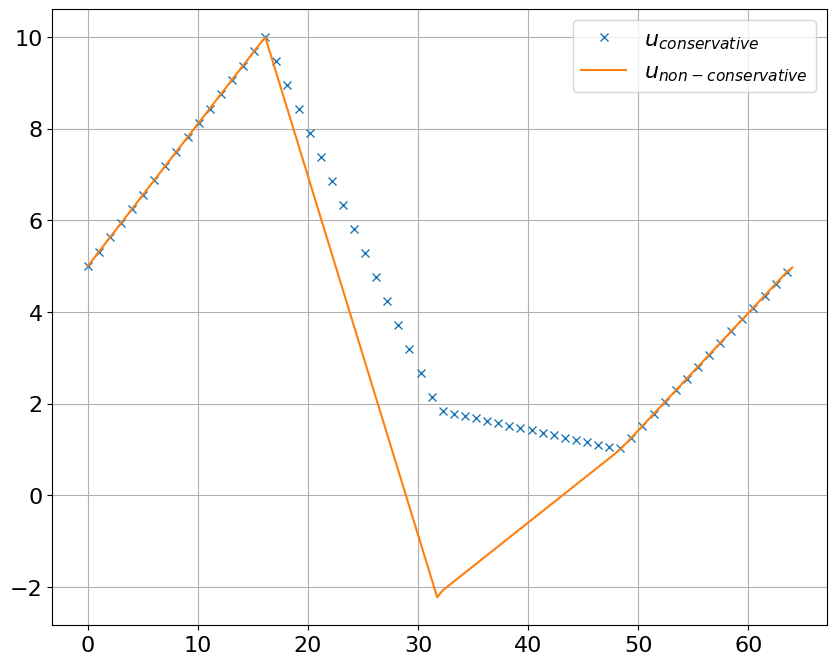

In [5]:
plt.rcParams.update({'font.size': 16})
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=1)
plt.plot(xspace, u_FD_conservative, label=r'$u_{conservative}$', marker='x', linestyle="", markevery=2)
plt.plot(xspace, u_FD_non_conservative, label=r'$u_{non-conservative}$')
axis.legend(loc="upper right")
plt.grid()